# Datasets
**Description:** This file contains code for defining custom datasets for FathomNet\
**Author:** Garðar Ingvarsson\
**Email:** gi241@cam.ac.uk
---

In [1]:
import torch
import os
import numpy as np
import json
from PIL import Image
import xml.etree.ElementTree as ET
import sys
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.append(os.path.join(Path(os.path.abspath('')).parent, 'utils'))

from fathomnethelper import Taxonomicon

In [2]:
class FathomNetDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'images'))))
        self.anns = list(sorted(os.listdir(os.path.join(root, 'annotations'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        ann_path = os.path.join(self.root, 'annotations', self.anns[idx])
        img = Image.open(img_path).convert('RGB')
        ann_tree = ET.parse(ann_path)
        root = ann_tree.getroot()
        names = []
        boxes = []
        for box in root.iter('object'):
            name = box.find('name').text
            xmin = int(box.find('bndbox/xmin').text)
            ymin = int(box.find('bndbox/ymin').text)
            xmax = int(box.find('bndbox/xmax').text)
            ymax = int(box.find('bndbox/ymax').text)
            names.append(name)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
    
class FathomNetCroppedDataset(torch.utils.data.Dataset):
    def __init__(self, root, rank, top_n, transforms=None):
        self.root = root
        self.transforms = transforms
        imgs = list(sorted(os.listdir(os.path.join(root, 'images'))))
        tax = Taxonomicon()
        
        concepts_at_rank = tax.get_concepts_at_rank(rank)
        subtrees_of_each_class = {concept: set(tax.get_subtree_nodes(concept)) for concept in concepts_at_rank}
        imgs_and_boxes = {concept: [] for concept in concepts_at_rank}
        
        for img in imgs:
            ann_tree = ET.parse(os.path.join(root, 'annotations', os.path.splitext(img)[0] + '.xml'))
            tree_root = ann_tree.getroot()
            for box in tree_root.iter('object'):
                name = box.find('name').text
                for clss in subtrees_of_each_class:
                    if name in subtrees_of_each_class[clss]:
                        xmin = int(box.find('bndbox/xmin').text)
                        ymin = int(box.find('bndbox/ymin').text)
                        xmax = int(box.find('bndbox/xmax').text)
                        ymax = int(box.find('bndbox/ymax').text)
                        imgs_and_boxes[clss].append((img, (xmin, ymin, xmax, ymax)))
        
        filtered = sorted(imgs_and_boxes.items(), key=lambda item: (len(item[1]), item[0]), reverse=True)[:top_n]
        self.boxes = []
        self.labels = []
        self.class_names = []
        for name, boxes in filtered:
            self.class_names.append(name)
            for box in boxes:
                self.boxes.append(box)
                self.labels.append(len(self.class_names))  # Map class names to integers
                
                
    def __len__(self):
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.boxes[idx][0])
        box = self.boxes[idx][1]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB').crop(box)
        label = torch.tensor([label])

        if self.transforms is not None:
            img = self.transforms(img)

        return img, label



0 tensor([1])


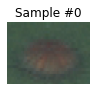

1 tensor([1])


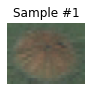

2 tensor([1])


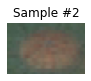

3 tensor([1])


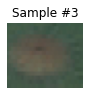

In [7]:
#dataset = FathomNetCroppedDataset(root='/home/gardar/PycharmProjects/deep-sea-organism-detection/data', rank='family', top_n=3) 
    

fig = plt.figure()

for i in range(4):
    im, label = dataset[i]

    print(i, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(im)
    plt.pause(0.01)

    if i == 3:
        plt.show()
        break

In [4]:
tree = ET.parse('/home/gardar/PycharmProjects/deep-sea-organism-detection/data/annotations/00003a28-8896-4bf9-95df-e57dc08c772e.xml')

In [5]:
root = tree.getroot()

In [6]:
root

<Element 'annotation' at 0x7f707c168d60>